# Task 3: Clustering (Unsupervised Learning)

### Description: Implement K-Means clustering to group data points into clusters without labels (e.g., customer segmentation).

- Apply K-Means clustering to the dataset.
- Use the elbow method or silhouette score to determine the optimal number of clusters.
- Visualize the clusters in 2D space using PCA or t-SNE for dimensionality reduction.
- Interpret the clustering results and summarize key findings.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Load data
churn_df = pd.read_csv("data/churn-bigml-20.csv")
churn_df.head(2)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True


In [4]:
churn_df.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [5]:
# Convert binary features
churn_df['International plan'] = churn_df['International plan'].map({'Yes': 1, 'No': 0})
churn_df['Voice mail plan'] = churn_df['Voice mail plan'].map({'Yes': 1, 'No': 0})

In [6]:
# Select features for clustering (Excluding State and the target Churn)
features = churn_df.drop(['State', 'Churn'], axis=1)

In [7]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

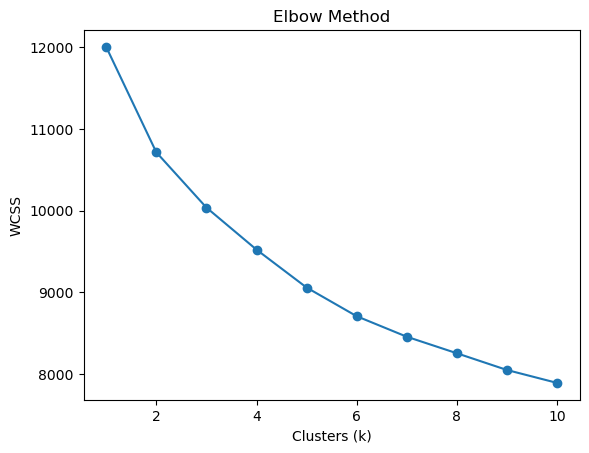

In [8]:
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_) 

plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters (k)')
plt.ylabel('WCSS')
plt.savefig("output/elbow_method_plot.png")
plt.show()

In [9]:
# pip install yellowbrick

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

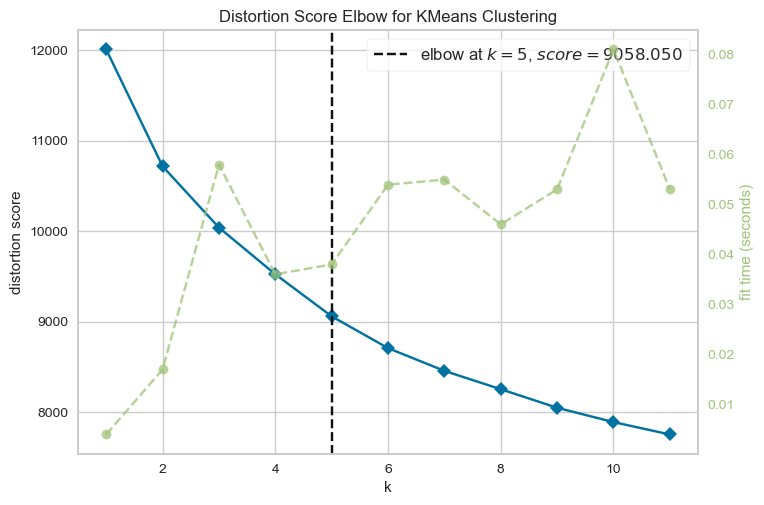

In [10]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# 'scaled_features' is your processed data
model = KMeans(n_clusters=8, random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(1, 12))
visualizer.fit(scaled_features)
visualizer.show(outpath="output/distortion_score_elbow_for_Kmeans.png")

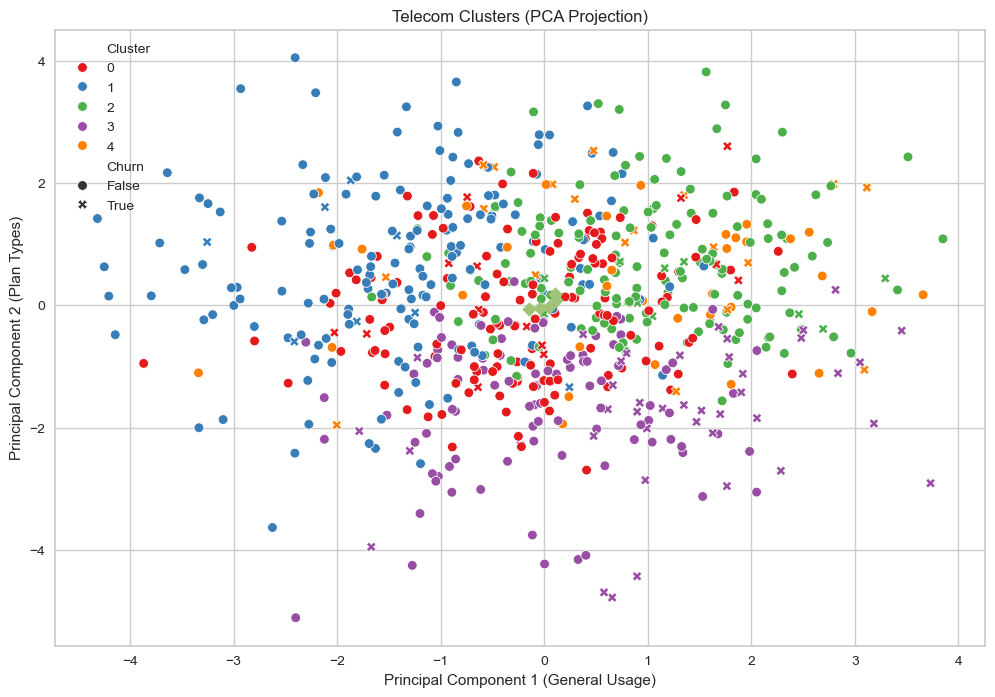

In [11]:
# Assuming k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
churn_df['Cluster'] = kmeans.fit_predict(scaled_features)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], 
                hue=churn_df['Cluster'], palette='Set1', style=churn_df['Churn'])

# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x, centroids_y,marker="D", s=50)
plt.title("Telecom Clusters (PCA Projection)")
plt.xlabel("Principal Component 1 (General Usage)")
plt.ylabel("Principal Component 2 (Plan Types)")
plt.savefig("output/telecom_clusers.png")
plt.show()

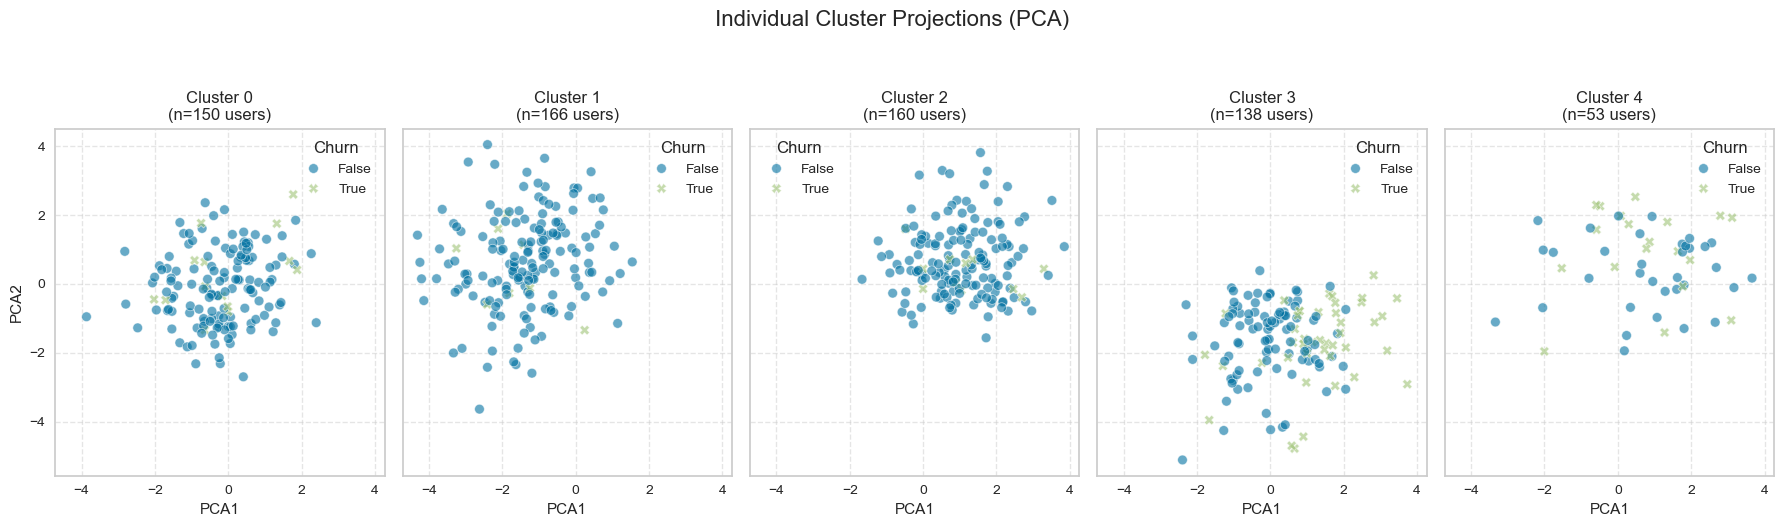

In [12]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)
churn_df['PCA1'] = pca_results[:, 0]
churn_df['PCA2'] = pca_results[:, 1]

# Get unique clusters
unique_clusters = sorted(churn_df['Cluster'].unique())
num_clusters = len(unique_clusters)

# Create the subplots (1 row, 'num_clusters' columns)
fig, axes = plt.subplots(1, num_clusters, figsize=(18, 5), sharex=True, sharey=True)

# 4. Loop through each cluster and plot it
for i, cluster_id in enumerate(unique_clusters):
    # Filter data for just this cluster
    cluster_data = churn_df[churn_df['Cluster'] == cluster_id]
    
    # Plot the specific cluster
    sns.scatterplot(
        data=cluster_data, 
        x='PCA1', 
        y='PCA2', 
        hue='Churn',
        style='Churn',
        ax=axes[i], 
        color=sns.color_palette("Set1")[i],
        alpha=0.6
    )
    
    # Add title and details
    axes[i].set_title(f'Cluster {cluster_id}\n(n={len(cluster_data)} users)')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Individual Cluster Projections (PCA)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


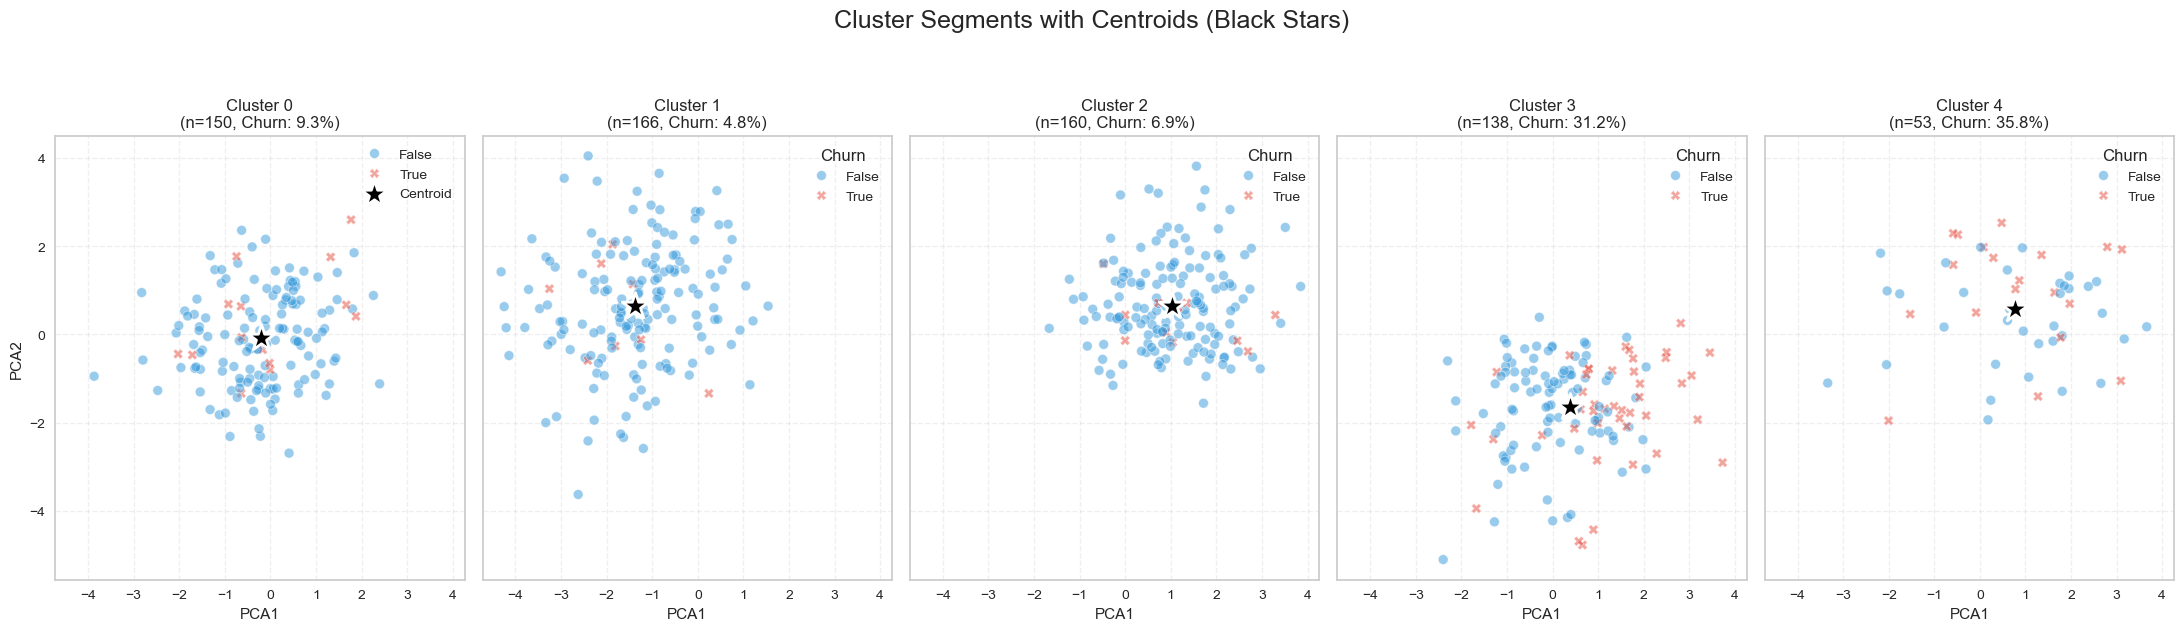

In [13]:
# Reduce data dimensions to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)
churn_df['PCA1'] = pca_results[:, 0]
churn_df['PCA2'] = pca_results[:, 1]

# Transform the High-Dimensional Centroids into 2D PCA space
# 'kmeans' is your fitted KMeans model
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Create the subplots
unique_clusters = sorted(churn_df['Cluster'].unique())
num_clusters = len(unique_clusters)
fig, axes = plt.subplots(1, num_clusters, figsize=(22, 6), sharex=True, sharey=True)

# Define a clear color palette for Churn
churn_palette = {True: "#e74c3c", False: "#3498db"}

for i, cluster_id in enumerate(unique_clusters):
    # Filter data for this cluster
    cluster_data = churn_df[churn_df['Cluster'] == cluster_id]
    
    # Calculate churn rate for the title
    c_rate = (cluster_data['Churn'].mean() * 100)
    
    # Plot the cluster points
    sns.scatterplot(
        data=cluster_data, 
        x='PCA1', 
        y='PCA2', 
        hue='Churn',
        style='Churn',
        palette=churn_palette,
        ax=axes[i], 
        alpha=0.5,
        s=50
    )
    
    # PLOT THE CENTROID for this specific cluster
    axes[i].scatter(
        centroids_pca[cluster_id, 0], 
        centroids_pca[cluster_id, 1], 
        color='black', 
        marker='*', 
        s=400, 
        label='Centroid',
        edgecolor='white',
        linewidth=2,
        zorder=10
    )
    
    # Styling
    axes[i].set_title(f'Cluster {cluster_id}\n(n={len(cluster_data)}, Churn: {c_rate:.1f}%)')
    axes[i].grid(True, linestyle='--', alpha=0.3)
    if i == 0: axes[i].legend()

plt.suptitle('Cluster Segments with Centroids (Black Stars)', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig("output/cluster_segments_with_centroids.png")
plt.show()

## Report

1. Cluster Breakdown and Interpretation
- Cluster 1 (Blue - Left): These users are on the far negative side of PC1 (General Usage). This suggests a "Low Usage" segment. They have fewer minutes, calls, and lower charges compared to the rest of the base.
- Cluster 2 (Green - Right): These are your "High Usage" users. Positioned on the far positive side of PC1, they likely represent customers with high day/evening minutes.
- Cluster 3 (Purple - Bottom): These users are separated by PC2 (Plan Types). Given your column list, this cluster likely identifies users with specific plan combinations, such as those with the International Plan or Voice Mail Plan active.
- Cluster 0 & 4 (Red/Orange - Center): These represent the "Average/Mainstream" users. They sit in the middle of the usage and plan spectrum. The overlap between these two suggests they are very similar, and a 4-cluster model might have been more distinct.

2. Churn Analysis (The 'X' Markers)
- Churn Hotspot in Cluster 2 (Green): There is a high density of 'x' (True) markers in the Green cluster. This indicates that your highest-usage customers are at the highest risk of leaving. They may be sensitive to high bills or are being targeted by competitors with better "unlimited" offers.
- Churn in Cluster 3 (Purple): There is a noticeable amount of churn here as well. This often points to dissatisfaction with specific value-added services, like the International Plan being too expensive or poor international call quality.
- Safety in Cluster 1 (Blue): Notice how few 'x' markers are on the far left. Low-usage customers churn less frequently; they are often "passive" subscribers who are less likely to shop around for new deals.

3. Key Findings & Action Plan
- Retention Focus: The immediate priority is the Green Cluster. Since they use the service the most, losing them represents the biggest revenue hit. Offering them a "High-Usage Loyalty Discount" could be effective.
- Service Check: Purple Cluster should be investigated more to check if their churn is related to Customer service calls. If they have an International Plan but high service calls, they are likely experiencing technical issues.
- PCA Variance: PC1 (Usage) clearly explains more of the difference between the customers than PC2 (Plans), as the horizontal spread is much wider than the vertical spread.